# Movie Recommendation Engine

Started as a follow-along project with [Dataquest's walkthrough](https://www.youtube.com/watch?v=eyEabQRBMQA), and ended up being a more fleshed out personal project.

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sq

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
def load_data(table_name: str) -> pd.DataFrame:
    '''
    Loads table from the movie_data sqlite database
    '''
    engine = sq.create_engine("sqlite:///data/movie_data.sql")
    with engine.connect() as cnx:
        return pd.read_sql(table_name, cnx)

In [3]:
def save_data(dataset: pd.DataFrame, table_name: str, if_exists: str = 'fail', index: bool = False) -> bool:
    '''
    Saves dataframe to the movie_data sqlite database
    '''
    engine = sq.create_engine("sqlite:///data/movie_data.sql")
    try:
        with engine.connect() as cnx:
            dataset.to_sql(name=table_name, con=cnx, if_exists=if_exists, index=index)
            return True
    except:
        print("Does this table already exist in movie_data.sql?")
        return False

In [4]:
def clean_title(title: str) -> str:
    '''
    Keeps only letters, numbers, whitespaces. 
    Replaces everything else with nothing.
    '''
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [5]:
def clean_genre(genre: str) -> list:
    '''
    Cleans the movies dataset genre columns so we can get a list of unique genres
    '''
    if '(' not in genre:
        genre_list = genre.split('|')
        return genre_list
    else:
        return ['None']

In [6]:
movies = load_data('movies')
ratings = pd.read_csv("data/ratings.csv")

links = load_data('links')
tags = load_data('tags')
genome_scores = pd.read_csv('data/genome-scores.csv')
genome_tags = load_data('genome_tags')

In [7]:
ratings[ratings['movieId'].isin([1,2,3,4])].groupby('movieId').mean()

,userId,rating,timestamp
movieId,,,
1,81294.564728,3.893708,1.153152e+09
2,81358.542554,3.251527,1.122310e+09
3,81343.694934,3.142028,9.806023e+08
4,81266.193024,2.853547,9.424605e+08


In [8]:
movies['cleaned_title'] = movies['title'].apply(clean_title)
movies.head()

,movieId,title,genres,cleaned_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995


# Search Engine

Converting words into numbers:

1. Term frequency: get frequency of words in title
1. Inverse document frequency: helps search engine find unique terms (the is in a lot of title, but harry is not)
1. Tf\*Idf: Get a vector for each movie

Search:

1. Convert search text into into numbers like above
1. Find row with the most number of matches via similarity

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tags = tags.dropna()

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(tags['tag'])

In [12]:
tfidf

<1093344x97929 sparse matrix of type '<class 'numpy.float64'>'
	with 2415931 stored elements in Compressed Sparse Row format>

In [13]:
# ngrams: number of words to search for together
# ex: Toy Story 1995: "toy", "story", "1995"; "toy story", "story 1995"
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(movies['cleaned_title'])

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title: str, dataframe: pd.DataFrame, tfidf) -> pd.DataFrame:
    '''
    Turns search term into a vectory, resulting top 5 results
    '''
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    # returns how similar search title is to each title
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    dataframe_cp = dataframe.copy()
    # find the 5 most similar titles by idx, in asc order
    # kinda like df['col'].sort_values(ascending=False).loc[:-5]
    indices = np.argpartition(similarity, -5)[-5:]
    dataframe_cp['similarity'] = similarity
    results = dataframe_cp.iloc[indices][::-1] # return with most similar up top
    return results

In [15]:
def check_genre(value: str, genre_list: list) -> bool:
    '''
    Returns true if any of genre from list is also in the given string.
    '''
    bool_list = [True if genre in value else False for genre in genre_list]
    if sum(bool_list) > 0:
        return True
    else: 
        return False

## Search Box

In [17]:
import ipywidgets as widgets
from IPython.display import display

In [18]:
movie_input = widgets.Text(
    value="Toy Story",
    description="Movie Title:",
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type,names='value')
display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

# Recommendation Engine

1. Find all users who liked the search title
1. Find the other movies that those users liked

In [19]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [20]:
movie_id = 1
high_rating = 4

In [21]:
# find the users that liked the movie being searched for
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings['rating']>=high_rating)]['userId'].unique()

# find the movies that similar users liked
similar_user_recs = ratings[(ratings['userId'].isin(similar_users)) & (ratings['rating']>=high_rating)]['movieId']

In [22]:
similar_users

array([     3,      5,      8, ..., 162530, 162533, 162534])

In [23]:
def negative_bold(val):


    bold = 'bold' if val < 0 else ''


    return 'font-weight: %s' % bold

In [24]:
from typing import List

def extract_string(my_string: str, terms_to_extract: List[str]) -> str:
    new_string = ''
    my_list = my_string.split('|')
    for term in terms_to_extract:
        if term.strip() in my_list:
            new_string += f"{term.strip()}|"
    return new_string

In [25]:
extract_string('i|am|groot', ['i', 'groot'])

'i|groot|'

In [26]:
# find the top 10% of movies
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
similar_user_recs = similar_user_recs[similar_user_recs > 0.1]
similar_user_recs

1       1.000000
318     0.549604
260     0.531518
356     0.517224
296     0.495744
          ...   
235     0.101249
1242    0.100931
1907    0.100772
3527    0.100613
2761    0.100135
Name: movieId, Length: 273, dtype: float64

In [27]:
# find what percent of people not similar to us liked these movies
# if normies like what i like, its highly likely the "similar users" liked my
# movie because everyone liked it

In [28]:
# all users who watched the movie recommended to us
all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]

In [29]:
# all users who watched the movie recommended to us
all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]
all_user_recs = all_users['movieId'].value_counts()/len(all_users['userId'].unique())

We need to find a movie where:

1. Everyone who liked search_term, also liked rec_term
1. Only X% (40%, ex) of those who liked rec_term also liked search_term

In [30]:
# percent of all users who liked the given movie
all_user_recs

318     0.440215
296     0.389659
356     0.367553
593     0.361897
2571    0.347994
          ...   
3175    0.049325
2081    0.047128
1282    0.044712
2761    0.039855
1907    0.039805
Name: movieId, Length: 273, dtype: float64

In [31]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ['similar_ppl','all_ppl']

In [32]:
rec_percentages

,similar_ppl,all_ppl
1,1.000000,0.235415
2,0.105598,0.051667
6,0.162879,0.097377
10,0.122623,0.072924
11,0.101408,0.058952
...,...,...
91529,0.120422,0.085416
99114,0.112732,0.091209
109487,0.117426,0.102603
112852,0.102681,0.067698


In [33]:
# score = ratio of similar:avg users who liked movie
rec_percentages['score'] = rec_percentages['similar_ppl'] / rec_percentages['all_ppl']
rec_percentages = rec_percentages.sort_values('score', ascending=False)

In [34]:
# left_index is the movieId
rec_percentages.head(10).merge(movies, left_index=True, right_on='movieId')

,similar_ppl,all_ppl,score,movieId,title,genres,cleaned_title
0,1.000000,0.235415,4.247819,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
3021,0.328914,0.102241,3.217054,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 2 1999
14813,0.161924,0.057710,2.805840,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,Toy Story 3 2010
2264,0.191095,0.068978,2.770367,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,Bugs Life A 1998
1992,0.120714,0.047128,2.561408,2081,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance,Little Mermaid The 1989
1818,0.100772,0.039805,2.531636,1907,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...,Mulan 1998
2669,0.100135,0.039855,2.512494,2761,"Iron Giant, The (1999)",Adventure|Animation|Children|Drama|Sci-Fi,Iron Giant The 1999
1005,0.128060,0.054719,2.340299,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical,Mary Poppins 1964
1047,0.231801,0.099113,2.338762,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,Willy Wonka the Chocolate Factory 1971
1249,0.103636,0.044712,2.317855,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,Fantasia 1940


Not bad! For `Toy Story` we recommended the Toy Story series, Bugs Life, etc.

In [35]:
def find_similar_movies(movie_id: int, high_rating: int = 4) -> pd.DataFrame:
    # find the users that liked the movie being searched for
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings['rating']>=high_rating)]['userId'].unique()
    # find the movies that similar users liked
    similar_user_recs = ratings[(ratings['userId'].isin(similar_users)) & (ratings['rating']>=high_rating)]['movieId']

    # find the top 10% of movies
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > 0.1]
    
    # all users who watched the movie recommended to us
    all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]
    all_user_recs = all_users['movieId'].value_counts()/len(all_users['userId'].unique())
    
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ['similar_ppl','all_ppl']

    # score = ratio of similar:avg users who liked movie
    rec_percentages['score'] = rec_percentages['similar_ppl'] / rec_percentages['all_ppl']
    rec_percentages = rec_percentages.sort_values('score', ascending=False)
    
    # left_index is the movieId
    return rec_percentages.head(10).merge(movies, left_index=True, right_on='movieId')[['score','title','genres']]

## Widget

In [36]:
movie_input_name = widgets.Text(
    initial_value = 'Toy Story',
    description = 'Movie Title:',
    disabled=False
)

In [37]:
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data['new']
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]['movieId']
            display(find_similar_movies(movie_id))

movie_input_name.observe(on_type, names='value')
display(movie_input_name, recommendation_list)

Text(value='', description='Movie Title:')

Output()

# Feature Engineering

Let's see if we can predict what rating a movie will get based on its genre, the year it was released, and semantics of user given tags.

## Extracting Release Year

In [85]:
movies['year'] = movies['title'].str.extract('\((\d\d\d\d)\)').astype(float)

In [86]:
movies['year'].isna().sum()

0

Since only 410 entries are NaN, we will drop them pending finding the years using IMDB API.

In [87]:
movies = movies.dropna(subset=['year'])

In [88]:
movies['year'].isna().sum()

0

In [89]:
import math
def round_to_decade(x):
    return int((x / 10.0)) * 10

In [90]:
movies['decade'] = movies['year'].astype(float).apply(roundup)

In [106]:
movies.head()

,movieId,title,genres,cleaned_title,year,year_format,decade,genres_lists
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,1995.0,1995-01-01,1990,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995,1995.0,1995-01-01,1990,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995,1995.0,1995-01-01,1990,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995,1995.0,1995-01-01,1990,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995,1995.0,1995-01-01,1990,[Comedy]


In [107]:
movies.shape

(62013, 8)

### EDA

In [92]:
movies.groupby('decade').count()

,movieId,title,genres,cleaned_title,year,year_format
decade,,,,,,
1870,2,2,2,2,2,2
1880,7,7,7,7,7,7
1890,108,108,108,108,108,108
1900,155,155,155,155,155,155
1910,239,239,239,239,239,239
1920,576,576,576,576,576,576
1930,2069,2069,2069,2069,2069,2069
1940,2326,2326,2326,2326,2326,2326
1950,2981,2981,2981,2981,2981,2981


Text(0.5, 1.0, 'Movies in database per decade')

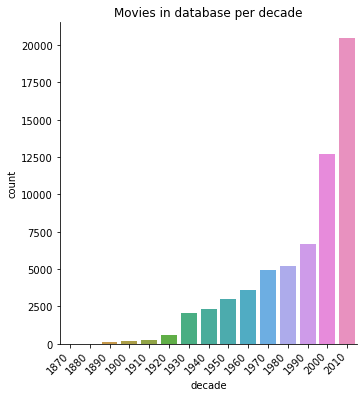

In [95]:
sns.catplot(x='decade', data=movies, kind='count')
plt.xticks(horizontalalignment='right', rotation=45)
plt.title('Movies in database per decade')

Will likely have to do stratified sampling since the yearly is so skewed.

## Dummifying Genre

In [97]:
# separate list of genres into dummy variables
def col_lists_to_dummies(dataframe: pd.DataFrame, col_of_lists: str, identifier: str) -> pd.DataFrame:
    '''
    Turns a series of lists into dummy variables, then merges the resulting df
    with the original df.

    input
    -----
    col_of_lists: name of column where each value is a list of strings
                  this column will be turned into dummy variables
    identifier: name of column where each value uniquely identifies the row
                this column will be used to merge on
    '''
    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # create an array of 1s and 0s representing whether or not each row belongs in the var
    dummy_array = mlb.fit_transform(dataframe[col_of_lists])
    # grab the unique vars to create new column names
    unique_vars_from_col_of_lists = mlb.classes_
    identifier_array = dataframe[identifier].values
    # create dummy dataframe
    dummy_df = pd.DataFrame(dummy_array, columns=unique_vars_from_col_of_lists, index=identifier_array).reset_index()
    dummy_df = dummy_df.rename({'index':identifier}, axis=1)

    return dummy_df, unique_vars_from_col_of_lists

In [124]:
movies['genres_lists'] = movies['genres'].apply(clean_genre)

# create dummy_df and get a unique list of genres
genre_dummies, unique_genres = col_lists_to_dummies(movies, 'genres_lists', 'movieId')
# mnerge dummy dataframe with original dataframe
movies_ml = movies.merge(genre_dummies, on='movieId').drop(['genres','genres_lists','year_format'], axis=1)
movies_ml.head()

,movieId,title,cleaned_title,year,decade,Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,None,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Toy Story 1995,1995.0,1990,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Jumanji 1995,1995.0,1990,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Grumpier Old Men 1995,1995.0,1990,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Waiting to Exhale 1995,1995.0,1990,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Father of the Bride Part II 1995,1995.0,1990,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### EDA

In [128]:
movies_per_genre = movies_ml[unique_genres.tolist() + ['movieId']].melt('movieId').groupby('variable').sum()
movies_per_genre = movies_per_genre.sort_values('value', ascending=False)[['value']].reset_index()
movies_per_genre.head()

,variable,value
0,Drama,25559
1,Comedy,16844
2,Thriller,8631
3,Romance,7708
4,Action,7335


Text(0.5, 1.0, 'Number of movies that belong to each genre')

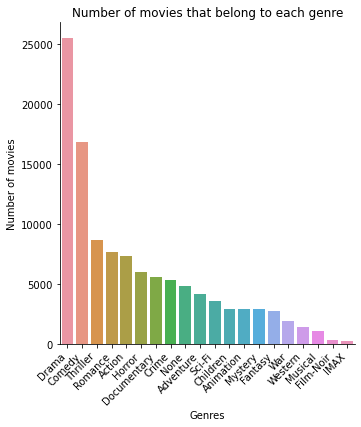

In [129]:
sns.catplot(x='variable', y='value', data=movies_per_genre, kind='bar')
plt.xticks(horizontalalignment='right', rotation=45)
plt.ylabel('Number of movies')
plt.xlabel('Genres')
plt.title('Number of movies that belong to each genre')

## User Ratings

In [130]:
movies.head()

,movieId,title,genres,cleaned_title,year,year_format,decade,genres_lists
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,1995.0,1995-01-01,1990,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995,1995.0,1995-01-01,1990,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995,1995.0,1995-01-01,1990,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995,1995.0,1995-01-01,1990,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995,1995.0,1995-01-01,1990,[Comedy]


In [131]:
# Show only the movies that were not dropped in the year section
ratings = ratings[ratings['movieId'].isin(movies['movieId'].unique())]
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [132]:
avg_ratings = ratings.groupby('movieId').mean().reset_index()[['movieId','rating']]
avg_ratings.head()

,movieId,rating
0,1,3.893708
1,2,3.251527
2,3,3.142028
3,4,2.853547
4,5,3.058434


In [133]:
avg_ratings.shape

(58675, 2)

In [134]:
movies_ml.shape

(62013, 25)

In [135]:
movies_ml = movies_ml.merge(avg_ratings, how='left')

In [137]:
movies_ml.isna().sum()

movieId             0
title               0
cleaned_title       0
year                0
decade              0
Action              0
Adventure           0
Animation           0
Children            0
Comedy              0
Crime               0
Documentary         0
Drama               0
Fantasy             0
Film-Noir           0
Horror              0
IMAX                0
Musical             0
Mystery             0
None                0
Romance             0
Sci-Fi              0
Thriller            0
War                 0
Western             0
rating           3338
dtype: int64

3338 movies were not rated by users, this is explored in EDA

In [153]:
movies_ml = movies_ml.dropna(subset=['rating'])
movies_ml.shape

(58675, 26)

By dropping 3338 records, we still have around 59k left. This is enough for ML.

### EDA

In [145]:
null_years = movies_ml[movies_ml['rating'].isna()]['decade'].value_counts()
null_years.sort_index()

1900     10
1910      6
1920     41
1930    395
1940    368
1950    412
1960    319
1970    548
1980    308
1990    281
2000    244
2010    406
Name: decade, dtype: int64

Text(3.674999999999997, 0.5, 'NaNs')

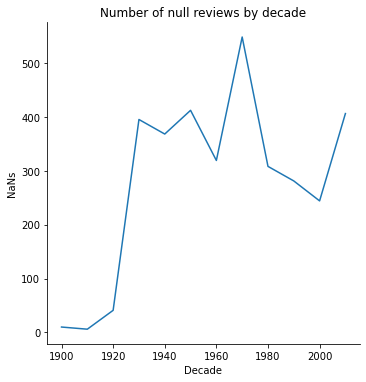

In [150]:
sns.relplot(x=null_years.index, y=null_years, kind='line')
plt.title('Number of null reviews by decade')
plt.xlabel('Decade')
plt.ylabel('NaNs')

## Semantic Analysis of Tags

In [158]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [159]:
sia = SentimentIntensityAnalyzer()

In [168]:
sia.polarity_scores('hi peter its matt')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [171]:
def tag_semantics(cell: str, res_type: str) -> float:
    '''
    Analyzes the given tag and returns it's compound score
    '''
    result = sia.polarity_scores(cell)
    return result[res_type]

In [174]:
for res_type in ['compound', 'pos', 'neg', 'neu']:
    tags[f'{res_type}_score'] = tags['tag'].apply(tag_semantics, res_type=res_type)

In [180]:
avg_sentiment = tags.groupby('movieId').mean().reset_index()[['movieId']+[col for col in tags.columns if 'score' in col]]
avg_sentiment

,movieId,compound_score,pos_score,neg_score,neu_score
0,1,0.082260,0.201674,0.007588,0.790737
1,2,-0.039925,0.027078,0.088889,0.884033
2,3,0.073579,0.107276,0.000000,0.892724
3,4,-0.018955,0.033182,0.090909,0.875909
4,5,0.010288,0.083333,0.033500,0.883167
...,...,...,...,...,...
45246,208813,0.361200,0.714000,0.000000,0.286000
45247,208933,-0.329850,0.000000,0.297500,0.702500
45248,209035,0.012867,0.166667,0.000000,0.833333
45249,209037,0.076360,0.200000,0.000000,0.800000


In [183]:
movies_ml = movies_ml.merge(avg_sentiment)
movies_ml.head()

,movieId,title,cleaned_title,year,decade,Action,Adventure,Animation,Children,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,rating,compound_score,pos_score,neg_score,neu_score
0,1,Toy Story (1995),Toy Story 1995,1995.0,1990,0,1,1,1,1,...,0,0,0,0,0,3.893708,0.082260,0.201674,0.007588,0.790737
1,2,Jumanji (1995),Jumanji 1995,1995.0,1990,0,1,0,1,0,...,0,0,0,0,0,3.251527,-0.039925,0.027078,0.088889,0.884033
2,3,Grumpier Old Men (1995),Grumpier Old Men 1995,1995.0,1990,0,0,0,0,1,...,1,0,0,0,0,3.142028,0.073579,0.107276,0.000000,0.892724
3,4,Waiting to Exhale (1995),Waiting to Exhale 1995,1995.0,1990,0,0,0,0,1,...,1,0,0,0,0,2.853547,-0.018955,0.033182,0.090909,0.875909
4,5,Father of the Bride Part II (1995),Father of the Bride Part II 1995,1995.0,1990,0,0,0,0,1,...,0,0,0,0,0,3.058434,0.010288,0.083333,0.033500,0.883167


{{ 58675-45251 }} movies in our dataset did not have tags and were dropped

# Predicting Movie Ratings

Let's see if we can predict what rating a movie will get based on its genre, the year it was released, and semantics of user given tags.

In [229]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Regressors

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [274]:
X = movies_ml.drop(['rating', 'title', 'movieId', 'cleaned_title', 'year'], axis=1)
y = movies_ml['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [279]:
def lr_train_predict(model):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    lr_metrics(y_test, predict)

In [280]:
def lr_metrics(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [282]:
print('LR')
lr = LinearRegression()
lr_train_predict(lr)

print('RF')
rf
lr_train_predict(rf)

LR
Mean Absolute Error: 0.4545024886719544
Mean Squared Error: 0.37255086668190657
Root Mean Squared Error: 0.6103694509736759
RF
Mean Absolute Error: 0.4576123161597519
Mean Squared Error: 0.38553240759868745
Root Mean Squared Error: 0.6209125603486271


Not the best, but not bad at all!

## Classifiers

In [248]:
from sklearn.ensemble import RandomForestClassifier

In [286]:
def rating_classification(cell: float) -> int:
    if cell > 4:
        return 3 # 'high'
    elif cell < 3:
        return 1 # 'low'
    else:
        return 2 #'medium'

In [283]:
def cr_train_predict(model):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    cr_metrics(y_test, predict)

In [285]:
def cr_metrics(y_test, y_pred):
    print('F2 Score:', metrics.fbeta_score(y_test, y_pred, beta=2, average='weighted'))
    print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
    print('Precision Score:', metrics.precision_score(y_test, y_pred, average='weighted'))

In [288]:
X = movies_ml.drop(['rating', 'title', 'movieId', 'cleaned_title', 'year'], axis=1)
y = movies_ml['rating']

y = y.apply(rating_classification)

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify=y)

In [290]:
rfc = RandomForestClassifier()
cr_train_predict(rfc)

F2 Score: 0.6405483751936434
Accuracy Score: 0.6514915538516832
Precision Score: 0.6236438506619818
